# HouseSalesPrediction

# DAY2

DAY1と同じデータに対して、前処理の改善や新しく学んだ手法の適用を行い、精度の改善を目指す  
まず、前処理として前回十分できていなかった、
- カテゴリカル変数の処理
- 説明変数の絞り込み
- 標準化
  
を実施する。    
そのうえで、新たに学んだ手法の適用を行い精度を評価する

### ライブラリの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image

### データの取り込み

In [2]:
df_data=pd.read_csv("../1_data/housesalesprediction/kc_house_data.csv")
df_data["price"]=df_data["price"]/10**6 #単位を100万ドルにしておく
#print(df_data.columns)
#print(df_data.head())

## 1.目的変数間と説明変数間のグラフ作成

In [3]:
#相間行列の作成
df_data.corr().style.background_gradient().format('{:.2f}')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01,-0.01,-0.01,0.02,-0.02,-0.01,-0.00,0.02,-0.00,-0.14
price,-0.02,1.00,0.31,0.53,0.70,0.09,0.26,0.27,0.40,0.04,0.67,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08
bedrooms,0.00,0.31,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03
bathrooms,0.01,0.53,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09
sqft_living,-0.01,0.70,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72
floors,0.02,0.26,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01
waterfront,-0.00,0.27,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.09,0.03,-0.01,-0.04,0.09,0.03
view,0.01,0.40,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.10,0.08,0.01,-0.08,0.28,0.07
condition,-0.02,0.04,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.00,-0.01,-0.11,-0.09,-0.00


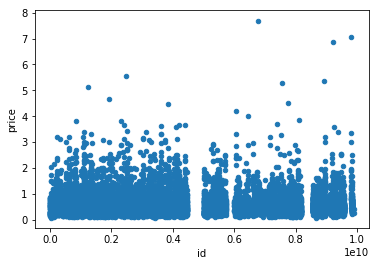

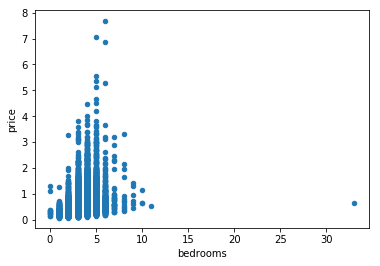

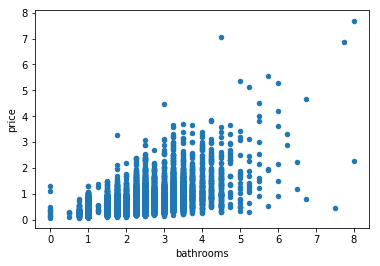

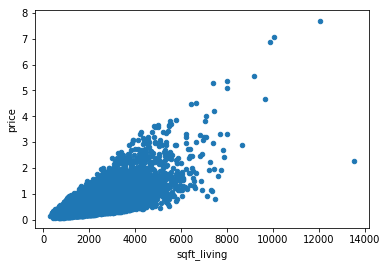

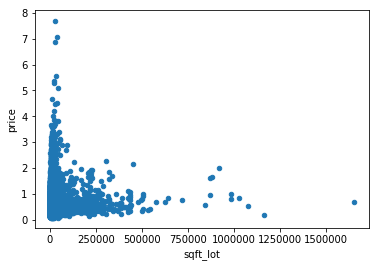

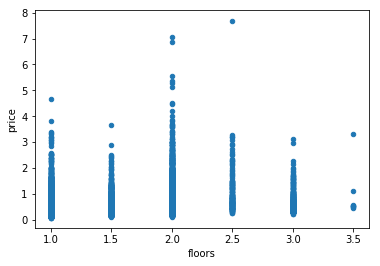

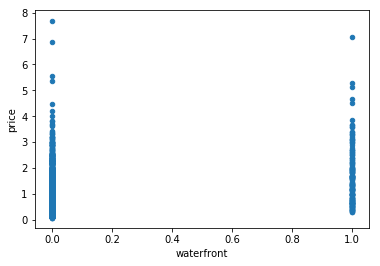

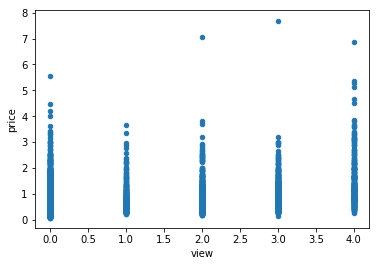

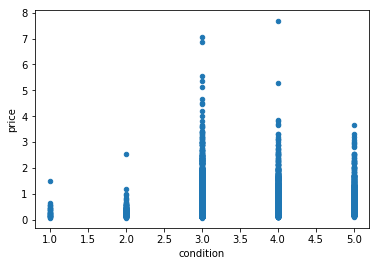

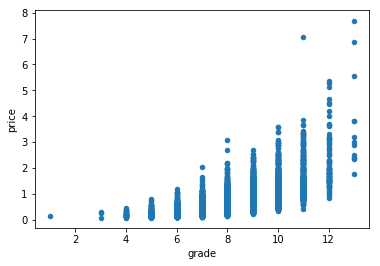

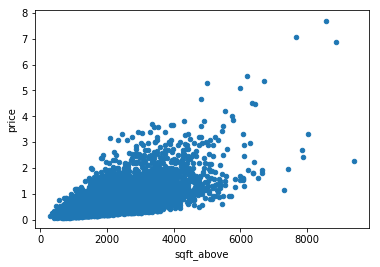

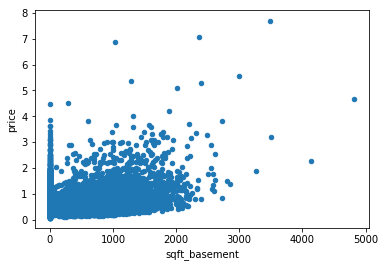

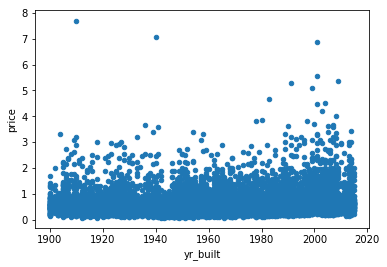

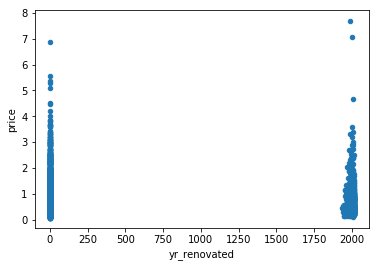

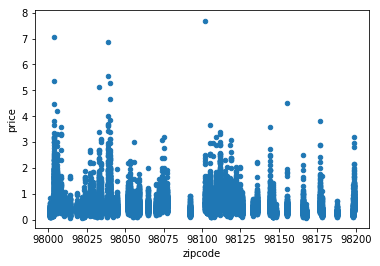

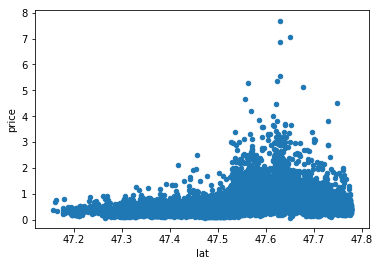

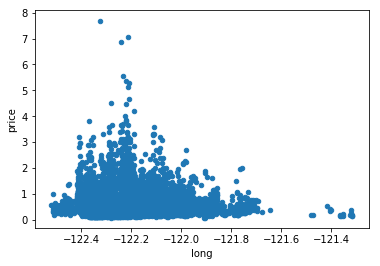

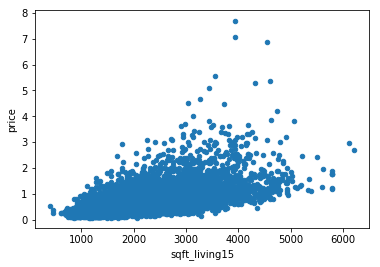

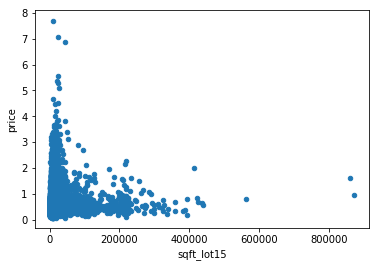

In [4]:
for col in df_data.columns:
    if (col != 'price') & ( col != 'date'):
        df_data[[col,'price']].plot(kind='scatter',x=col,y='price')

下記のデータは相間図が直線に近く、目的変数との関連が高そうに見える
- bathroom  
- sqft_living  
- grade  
- sqft_above  
- sqft_living15  

## 2.欠測値と異常値の処理

### 欠測値の処理

In [5]:
# そもそも欠測値があるのかどうか調べる
# coutn missing
pd.DataFrame(df_data.isnull().sum(), columns=["num of missing"])

,num of missing
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [6]:
# 線形補間を実施(欠測値なしのため特に処理は走らないはず)
for col in df_data.columns:
    df_data[col]=df_data[col].interpolate()
# print(df_data.head())

### 異常値の確認

上記の散布図を見ると、外れたところにあるものが見受けられる  
bedrooms:30付近 
sqft_living: 14000付近  

この2変数だけを散布図をもう一度確認してみる

C:\Users\y-izumi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\y-izumi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\y-izumi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\y-izumi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


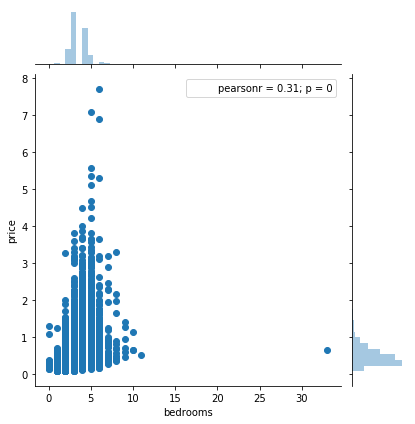

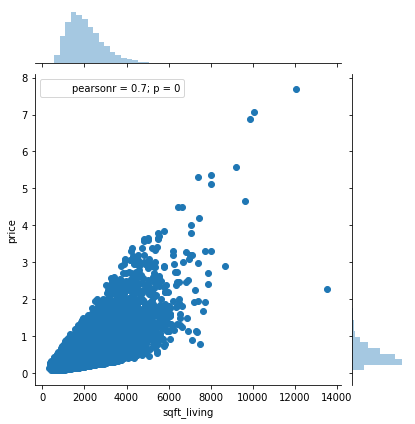

In [7]:
for col in "bedrooms","sqft_living":
    sns.jointplot(col,"price",data=df_data)

sqft_livingは全体の傾向から外れているわけではないので、異常値として処理する必要はなさそう  
bedroomsも大きく外れているわけではないが、そもそも全体的な傾向が分かりづらいのでデータを確認する

In [8]:
# それぞれのケースを確認
print(df_data.iloc[df_data["bedrooms"].idxmax()])

id                    2402100895
date             20140625T000000
price                       0.64
bedrooms                      33
bathrooms                   1.75
sqft_living                 1620
sqft_lot                    6000
floors                         1
waterfront                     0
view                           0
condition                      5
grade                          7
sqft_above                  1040
sqft_basement                580
yr_built                    1947
yr_renovated                   0
zipcode                    98103
lat                      47.6878
long                    -122.331
sqft_living15               1330
sqft_lot15                  4700
Name: 15870, dtype: object


priceとの関連が高そうに見えた、sqft_livingやgradeの値が低く、bedrooms数が31と多くてもpriceがそれほど高くない理由となっていそう  
そのため特に異常値としては扱わない

## 3.特徴量エンジニアリング

In [9]:
# データタイプの確認
for col in df_data.columns:
    print("{0} : {1}".format(col,df_data[col].dtype))

id : int64
date : object
price : float64
bedrooms : int64
bathrooms : float64
sqft_living : int64
sqft_lot : int64
floors : float64
waterfront : int64
view : int64
condition : int64
grade : int64
sqft_above : int64
sqft_basement : int64
yr_built : int64
yr_renovated : int64
zipcode : int64
lat : float64
long : float64
sqft_living15 : int64
sqft_lot15 : int64


dateの型がobjectになっているため、日付に変換

In [10]:
df_data["date"]=pd.to_datetime(df_data.date)
# print(df_data.date.head())

# datetimeオブジェクトはそのまま扱えないため、年月日それぞれに分ける
df_data["sold_year"] = df_data["date"].map(lambda x: x.year)
df_data["sold_month"] = df_data["date"].map(lambda x: x.month)
df_data["sold_day"] = df_data["date"].map(lambda x: x.day)
print(df_data["sold_year"].head())
print(df_data["sold_month"].head())
print(df_data["sold_day"].head())


# 年月日のデータを抽出したので、代わりにdateはdropさせる
df_data_01 = df_data.drop("date",1)


0    2014
1    2014
2    2015
3    2014
4    2015
Name: sold_year, dtype: int64
0    10
1    12
2     2
3    12
4     2
Name: sold_month, dtype: int64
0    13
1     9
2    25
3     9
4    18
Name: sold_day, dtype: int64


### カテゴリカル変数のone-hotベクトルへの変換

zipcodeはカテゴリカル変数と考えられるのでone-hotベクトルへの変換を行う

In [11]:
df_data_01['zipcode_str'] = df_data_01['zipcode'].astype(str).map(lambda x:'zip_'+x)
df_data_01_en = pd.concat([df_data_01,pd.get_dummies(df_data_01['zipcode_str'])],axis=1)

#one-hotベクトルへの変換したので元の変数は捨てる
df_data_01_2 = df_data_01_en.drop(['zipcode','zipcode_str'],axis=1)

月日もカテゴリカル変数として扱うべきかどうか？  
月日については順序関係自体はあるため、one-hotベクトル化するのも考えものでは？(1月と2月であれば似た傾向がみられるのでは)  
そのため、ここでは数値のまま残しておく

In [12]:
# リノベーション年はリノベーションしたかどうかに変換する
df_data_01_2['yr_renovated_bin'] = np.array(df_data_01_2['yr_renovated'] != 0)*1
df_data_01_2['yr_renovated_bin'].value_counts().sort_index()

0    20699
1      914
Name: yr_renovated_bin, dtype: int64

In [13]:
# リノベーションした年のデータは捨てる
df_data_02 = df_data_01_2.drop("yr_renovated",axis=1)

In [14]:
# display(df_data_02)

### 多重共線性の確認

多重共線性を確認するためVIFを計算する

In [15]:
from sklearn.linear_model import LinearRegression

df_data_vif = df_data_02.drop(["price"],axis=1)
for cname in df_data_vif.columns:  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
    rsquared = regr.score(X_vif,y_vif)
    print(cname,":" ,1/(1-np.power(rsquared,2)))

id : 1.0064114511043827
bedrooms : 1.2033424434927997
bathrooms : 2.0015557715072463
sqft_living : inf


C:\Users\y-izumi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


sqft_lot : 1.3897326880331975
floors : 1.533512056938758
waterfront : 1.0422340422967369
view : 1.1306727903574902
condition : 1.0625944278962092
grade : 2.1956762352612413
sqft_above : inf
sqft_basement : inf
yr_built : 1.821770741819205
lat : 32.53630678737257
long : 17.44915689421001
sqft_living15 : 1.9348068863768186
sqft_lot15 : 1.4651328679372686
sold_year : 1.6216219851634204
sold_month : 1.6205854239018767
sold_day : 1.0002263252134478
zip_98001 : 326087873967.88763
zip_98002 : 5512361845006.727
zip_98003 : 354335139840.32227
zip_98004 : 902524975424.9491
zip_98005 : 1276168780779.3982
zip_98006 : 8744853645379.604
zip_98007 : 5037583475805.924
zip_98008 : 395295324091.1521
zip_98010 : 7942856485662.25
zip_98011 : 3845943319701.5337
zip_98014 : 503589357863.18866
zip_98019 : 973120057772.363
zip_98022 : 278446867031.6864
zip_98023 : 60815075855.05842
zip_98024 : 1808674549144.7776
zip_98027 : 817053633412.6444
zip_98028 : 2331055707748.704
zip_98029 : 74571550136.1167
zip_98030

多重共線性を確認したところsqft_living、sqft_above、sqft_basementのVIFが無限大となっている 
(エラーが出ているが、doubleの丸めにより0で割る形になったのが原因らしい)

また、zipcode関連もVIFが大きな値を示している  
多重共線性があると予想されるため、偏回帰係数を求めることでどの変数間に多重共線性があるか確認する

In [16]:
for cname in "sqft_living","sqft_above","sqft_basement":  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
#     print(X_vif.columns)
#     print(regr.coef_)
    coef = pd.DataFrame(columns=X_vif.columns,data=[regr.coef_])
#     print(cname,":" ,regr.coef_)
    pd.set_option('display.max_columns', None)
    print(cname)
    display(coef)

sqft_living


,id,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,sold_year,sold_month,sold_day,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_renovated_bin
0,-2.215825e-18,-2.943441e-11,-2.577415e-10,-4.329870e-15,5.338539e-10,-8.358107e-10,-8.385237e-11,-2.017595e-10,5.964634e-10,1.0,1.0,-1.819871e-11,-2.145272e-08,1.756001e-08,-1.788586e-13,-5.242334e-15,-3.191221e-10,-3.600738e-11,-2.710460e-12,-9.395324e-10,-2.618786e-09,-2.170606e-09,1.125984e-09,3.865231e-09,-7.440523e-10,-2.179738e-09,1.108287e-09,-7.576253e-09,1.638416e-09,-1.214285e-09,-7.092293e-09,-7.046783e-09,1.833220e-09,-1.228555e-09,-1.747554e-09,1.302805e-09,-1.509814e-09,-2.188401e-09,-1.703928e-09,-2.066848e-09,-1.339355e-09,2.879362e-11,2.026409e-09,1.243908e-08,2.287106e-09,-2.722223e-09,-4.955323e-09,-3.842277e-09,3.214471e-10,-2.206884e-09,-2.905906e-09,-2.124485e-09,-3.576523e-10,-6.731504e-09,1.594430e-09,9.087404e-10,-3.777763e-09,-2.295534e-09,-3.532503e-09,-3.544130e-09,1.844776e-09,1.028152e-09,5.536955e-09,4.379794e-10,7.602948e-09,4.606268e-09,-1.381196e-09,4.749866e-09,8.588757e-10,3.315439e-09,4.942120e-09,3.537743e-09,4.632794e-09,6.418854e-10,2.686446e-09,3.290026e-09,3.314517e-09,2.246862e-09,1.363387e-09,-1.484316e-10,-1.661611e-08,2.800242e-09,1.082228e-09,3.050371e-09,4.646454e-09,1.406522e-09,-1.409210e-09,-2.580158e-09,4.395267e-09,9.598016e-10


sqft_above


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,sold_year,sold_month,sold_day,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_renovated_bin
0,-2.133751e-18,-4.088643e-12,1.903800e-10,1.0,2.553513e-15,-3.424165e-10,2.700147e-10,7.654921e-11,1.202255e-10,-4.041406e-10,-1.0,1.194894e-11,1.440511e-08,-1.180117e-08,1.151490e-13,4.484911e-15,1.994766e-10,2.289694e-11,1.790928e-12,8.534702e-10,1.996356e-09,1.452902e-09,-6.469716e-10,-2.206420e-09,5.483783e-10,1.550530e-09,-5.603842e-10,4.731313e-09,-1.156175e-09,1.172322e-10,4.699720e-09,4.797278e-09,-1.434173e-09,8.195625e-10,1.107078e-09,-8.430529e-10,9.507627e-10,1.416322e-09,1.156579e-09,1.718114e-09,7.121287e-10,-1.228338e-10,-1.350932e-09,-8.388879e-09,-1.579300e-09,2.187879e-09,3.523256e-09,2.540162e-09,-3.470335e-10,1.669565e-09,1.885314e-09,1.428073e-09,1.527629e-10,4.552635e-09,-1.869310e-09,-5.750114e-10,2.587055e-09,1.551773e-09,2.439647e-09,2.372338e-09,-8.322421e-10,-7.251061e-10,-3.655422e-09,-2.614954e-10,-5.117190e-09,-3.541197e-09,7.503904e-10,-3.115527e-09,-6.366951e-10,-2.256199e-09,-3.275726e-09,-2.525861e-09,-3.334309e-09,-5.443041e-10,-1.796715e-09,-2.356096e-09,-1.875915e-09,-1.302046e-09,-7.237436e-10,8.831425e-11,1.111028e-08,-1.537745e-09,-6.512257e-10,-2.069078e-09,-3.068190e-09,-9.002392e-10,9.000119e-10,1.767237e-09,-2.951673e-09,-6.731685e-10


sqft_basement


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15,sold_year,sold_month,sold_day,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_renovated_bin
0,-8.219438e-20,-3.297467e-11,-4.556367e-10,1.0,-7.105427e-15,8.756745e-10,-1.103607e-09,-1.598883e-10,-3.218867e-10,1.000447e-09,-1.0,-3.016149e-11,-3.585765e-08,2.936238e-08,-2.913405e-13,-1.017719e-14,-5.186298e-10,-5.890094e-11,-4.502420e-12,-1.792908e-09,-4.615083e-09,-3.623526e-09,1.772948e-09,6.071685e-09,-1.292396e-09,-3.730935e-09,1.668680e-09,-1.230737e-08,2.794562e-09,-1.331390e-09,-1.179195e-08,-1.184383e-08,3.267463e-09,-2.048098e-09,-2.854557e-09,2.145366e-09,-2.460488e-09,-3.604614e-09,-2.860430e-09,-3.784888e-09,-2.051531e-09,1.515906e-10,3.377487e-09,2.082765e-08,3.866418e-09,-4.909965e-09,-8.478353e-09,-6.382394e-09,6.684490e-10,-3.876384e-09,-4.791188e-09,-3.552471e-09,-5.103441e-10,-1.128400e-08,3.463725e-09,1.483774e-09,-6.364749e-09,-3.847190e-09,-5.972133e-09,-5.916344e-09,2.676938e-09,1.753158e-09,9.192322e-09,6.994322e-10,1.272002e-08,8.147463e-09,-2.131618e-09,7.865426e-09,1.495544e-09,5.571588e-09,8.217761e-09,6.063637e-09,7.967071e-09,1.186173e-09,4.482948e-09,5.646101e-09,5.190310e-09,3.549025e-09,2.087145e-09,-2.368707e-10,-2.772637e-08,4.337889e-09,1.733458e-09,5.119473e-09,7.714529e-09,2.306796e-09,-2.309157e-09,-4.347385e-09,7.346891e-09,1.632953e-09


sqft_living、sqft_above、sqft_basementの3変数間での多重共線性が確認できる  
sqft_livingのみ残してsqft_above、sqft_basementはdropする

In [17]:
drop_col = ["sqft_above", "sqft_basement"]
df_data_02_1=df_data_02.drop(drop_col,1)

zipcode周りについても変数間の多重共線性を確認する  
試しにzip_98001のみを選んで偏回帰係数を計算する

In [18]:
for cname in "zip_98001",:  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
#     print(X_vif.columns)
#     print(regr.coef_)
    coef = pd.DataFrame(columns=X_vif.columns,data=[regr.coef_])
#     print(cname,":" ,regr.coef_)
    pd.set_option('display.max_columns', None)
    print(cname)
    display(coef)

zip_98001


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,sold_year,sold_month,sold_day,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,yr_renovated_bin
0,-7.167308e-20,1.719446e-09,1.290436e-08,-1.388357e-10,-1.543464e-13,1.519294e-08,-4.560199e-07,5.220125e-09,-6.216168e-09,2.209842e-08,1.194554e-10,1.377768e-10,-6.193595e-10,3.347534e-07,-1.517797e-08,1.863274e-11,-2.712421e-13,-1.750380e-09,-3.035872e-10,5.246343e-11,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-3.529491e-08


自身以外のすべてのzipcodeに対し、決定係数が-1となっている  
考えてみれば、one-hotベクトルを使用した場合、あるカテゴリに所属する場合、他のカテゴリには所属しないのでこの結果は当然  
一列だけでもdropさせることで多重共線性は解消できると思われる

In [19]:
df_data_02_2=df_data_02_1.drop("zip_98001",1)
# print(df_data_02_2.head())

再度、VIFの計算を行う

In [20]:
df_data_vif = df_data_02_2.drop(["price"],axis=1)
for cname in df_data_vif.columns:  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
    rsquared = regr.score(X_vif,y_vif)
    vif =1/(1-np.power(rsquared,2))
    if(vif>10): print(cname,":" ,vif)

lat : 32.53603940413249
long : 17.43533741671429


10以上のVIFを持つ変数を探したところ、latとlogが見つかった  
この2変数についても偏回帰係数を計算する

In [21]:
for cname in "lat","long",:  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
#     print(X_vif.columns)
#     print(regr.coef_)
    coef = pd.DataFrame(columns=X_vif.columns,data=[regr.coef_])
    coef.sort_values(by=0,axis=1,ascending=False, inplace=True)
#     print(cname,":" ,regr.coef_)
    pd.set_option('display.max_columns', None)
    print(cname)
    display(coef)

lat


,zip_98011,zip_98072,zip_98028,zip_98077,zip_98155,zip_98019,zip_98177,zip_98133,zip_98034,zip_98125,zip_98014,zip_98053,zip_98052,zip_98033,zip_98115,zip_98117,zip_98103,zip_98107,zip_98105,zip_98199,zip_98119,zip_98074,zip_98102,zip_98109,zip_98112,zip_98039,zip_98008,zip_98004,zip_98007,zip_98005,zip_98122,zip_98075,zip_98144,zip_98024,zip_98029,zip_98116,zip_98006,zip_98040,zip_98065,zip_98108,zip_98118,zip_98126,zip_98136,zip_98027,zip_98106,zip_98056,zip_98178,zip_98059,zip_98045,zip_98146,zip_98168,zip_98055,zip_98058,zip_98166,zip_98188,zip_98148,zip_98070,zip_98031,zip_98198,zip_98038,zip_98042,zip_98032,zip_98030,zip_98010,zip_98003,zip_98002,yr_renovated_bin,sold_year,grade,sold_month,sold_day,yr_built,sqft_living15,sqft_lot15,id,sqft_lot,sqft_living,bathrooms,bedrooms,view,condition,floors,zip_98092,waterfront,zip_98023,long,zip_98022
0,0.449322,0.448487,0.447142,0.446984,0.444221,0.444046,0.428365,0.423194,0.41474,0.406684,0.383789,0.382525,0.378709,0.375214,0.375079,0.372949,0.364194,0.356474,0.355288,0.332908,0.326769,0.325758,0.32361,0.323232,0.319414,0.31795,0.31215,0.309816,0.307845,0.307032,0.299908,0.290421,0.27657,0.267881,0.263767,0.259151,0.254834,0.253094,0.242793,0.23919,0.234806,0.230652,0.224313,0.22393,0.223073,0.205396,0.191655,0.190215,0.189853,0.188865,0.178983,0.152974,0.143243,0.142737,0.137729,0.125025,0.100954,0.098911,0.07974,0.073626,0.064469,0.06423,0.063976,0.037986,0.004512,0.003164,0.000989,0.000602,0.000461,0.000032,0.000013,0.000005,5.299672e-07,2.393200e-09,1.175390e-13,-5.752086e-09,-1.048055e-07,-0.000068,-0.000188,-0.00048,-0.000842,-0.001559,-0.002023,-0.00506,-0.00543,-0.04993,-0.083068


long


,zip_98045,zip_98014,zip_98065,zip_98024,zip_98019,zip_98029,zip_98053,zip_98075,zip_98010,zip_98022,zip_98074,zip_98077,zip_98027,zip_98038,zip_98052,zip_98008,zip_98072,zip_98042,zip_98007,zip_98059,zip_98006,zip_98058,zip_98005,zip_98033,zip_98011,zip_98056,zip_98034,zip_98092,zip_98004,zip_98031,zip_98030,zip_98055,zip_98040,zip_98028,zip_98039,zip_98002,zip_98178,zip_98118,zip_98105,zip_98155,zip_98125,zip_98115,zip_98112,zip_98188,zip_98122,yr_renovated_bin,zip_98144,yr_built,sqft_living,sqft_lot15,sqft_lot,id,sqft_living15,sold_day,sold_year,sold_month,condition,bedrooms,floors,view,bathrooms,grade,zip_98032,waterfront,zip_98108,zip_98102,zip_98168,zip_98133,zip_98103,zip_98198,zip_98003,zip_98109,zip_98148,zip_98177,zip_98119,zip_98106,zip_98166,zip_98146,zip_98107,zip_98117,zip_98126,zip_98023,zip_98199,zip_98136,zip_98116,lat,zip_98070
0,0.525523,0.450977,0.430281,0.383222,0.354664,0.290097,0.281952,0.275504,0.269891,0.262514,0.25689,0.248954,0.247236,0.243801,0.187965,0.185479,0.180499,0.160269,0.158655,0.149278,0.148799,0.137573,0.132932,0.119537,0.113051,0.107799,0.103855,0.100341,0.095748,0.090956,0.086292,0.083046,0.070621,0.068231,0.068011,0.057727,0.043242,0.019152,0.013297,0.011067,0.010097,0.006972,0.006139,0.003456,0.002425,0.001985,0.000895,0.000034,0.000001,7.006666e-08,1.639155e-08,-8.407323e-14,-3.014588e-07,-0.000009,-0.000031,-0.000057,-0.000057,-0.000279,-0.000435,-0.000503,-0.000684,-0.000731,-0.001426,-0.008104,-0.011624,-0.017635,-0.01951,-0.030953,-0.035912,-0.036225,-0.038247,-0.045317,-0.045583,-0.055725,-0.061677,-0.063277,-0.064523,-0.068068,-0.068103,-0.069645,-0.080352,-0.093145,-0.093235,-0.09358,-0.095441,-0.09691,-0.186841


lat,longともにzipcodeとの関連が見受けられる  
lat,longはそれぞれ緯度経度のことなので、zipcodeとの相関が高いのは自然  

住宅価格を予想するにあたっては、緯度経度よりはどの地区の住宅か？のほうが重要だと考え、lat,longはdropさせる

In [22]:
drop_col=["lat","long"]
df_data_02_3 = df_data_02_2.drop(drop_col,axis=1)

In [23]:
df_data_vif = df_data_02_3.drop(["price"],axis=1)
for cname in df_data_vif.columns:  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
    rsquared = regr.score(X_vif,y_vif)
    vif =1/(1-np.power(rsquared,2))
    if(vif>10): print(cname,":" ,vif)

10以上のVIFをもつ説明変数がなくなり、多重共線性を解消することができた

In [24]:
df_data_03=df_data_02_3
# print(df_data_03)

ここまでのまとめ
- 欠損値、異常値は見つからなかった
- 日付データは年、月、日に分けた
- リノベーション年はリノベーションしたかどうかに変換した
- zipcodeはone-hotベクトルに変換した多重共線性を解消させるため1列を削除した
- sqft_living,sqft_above、sqft_basementの3変数間で多重共線性が確認されたため、sqft_above、sqft_basementを削除した
- lat,longは特定のzipcodeとの多重共線性が確認でき、緯度経度より地区の情報のほうが重要と考え削除した

## 4.モデルの作成と精度の評価

ここからはモデルの作成と交差検証によるハイパーパラメータの探索を行い、その精度を評価する  
モデルとしては下記のものを使う  
- 線形回帰
- 1つの決定木の利用
- ランダムフォレスト

モデルを作成する前に、使用する説明変数の絞り込みと、標準化を行う

In [25]:
# 説明変数と目的変数に分ける

# 相関係数が0.3以上の変数を抽出し、説明変数として設定する
# 目的変数はprice
corr = pd.DataFrame(columns=df_data_03.columns,data= df_data_03.corr())
# print(corr.loc["price","bedrooms"])

# print(df_data_03.columns)
X_columns=[]
for col in df_data_03.columns:
    if(corr.loc["price",col]>0.2):
        X_columns.append(col)
# print(X_columns)
X=df_data_03[X_columns]
X=X.drop("price",1)
Y=df_data_03["price"]
# print(X.head())
# print(Y.head())
print(X.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade', 'sqft_living15', 'zip_98004', 'zip_98039', 'zip_98040'],
      dtype='object')


In [26]:
# # 相関行列を確認し、実際に相関係数が閾値以上の目的変数が抽出されていることを確認
# df_corr = df_data_03.corr()
# df_corr.sort_values(by="price",axis=0,ascending=False, inplace=True)
# df_corr.style.background_gradient().format('{:.2f}')

### 説明変数の標準化

In [27]:
# 説明変数の標準化を行う

from sklearn.preprocessing import StandardScaler
stdsc=StandardScaler()
# print(stdsc.fit_transform(X))
X_std = pd.DataFrame(columns=X.columns,data=stdsc.fit_transform(X))
# X_std = stdsc.fit_transform(X)

display(X_std.head())

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_living15,zip_98004,zip_98039,zip_98040
0,-0.398737,-1.447464,-0.979835,-0.915427,-0.087173,-0.305759,-0.558836,-0.943355,-0.122006,-0.048154,-0.114979
1,-0.398737,0.175607,0.533634,0.936506,-0.087173,-0.305759,-0.558836,-0.432686,-0.122006,-0.048154,-0.114979
2,-1.473959,-1.447464,-1.426254,-0.915427,-0.087173,-0.305759,-1.409587,1.070140,-0.122006,-0.048154,-0.114979
3,0.676485,1.149449,-0.130550,-0.915427,-0.087173,-0.305759,-0.558836,-0.914174,-0.122006,-0.048154,-0.114979
4,-0.398737,-0.149007,-0.435422,-0.915427,-0.087173,-0.305759,0.291916,-0.272190,-0.122006,-0.048154,-0.114979


In [28]:
# 2割をテストデータとして利用
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=3)


### (a)線形回帰を使った場合

In [29]:
from sklearn.linear_model import LinearRegression

#回帰
regr_lin = LinearRegression(fit_intercept=True)
regr_lin.fit(X_train,Y_train)

# 回帰変数および回帰切片の表示
print(regr_lin.coef_)
print(regr_lin.intercept_)
#print(regr.get_params())

#決定係数の表示
print("決定係数=%s"%round(regr_lin.score(X_test,Y_test),3))

[-2.95115345e-02 -1.27156042e-02  1.91300729e-04 -9.04632512e-03
  5.42385889e-01  7.12444564e-02  8.93599974e-02 -1.89729939e-05
  6.08140137e-01  1.22288444e+00  3.36532198e-01]
-0.4011513033983557
決定係数=0.675


In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error

#MSE,RMSE,MAEの計算
Y_pred=regr_lin.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y_test,Y_pred)

acr1_0=pd.DataFrame({'Model' : ["DAY1"],
                    'MSE' : [0.037],
                    'RMSE' : [0.193],
                  'MAE' : [0.123],})

acr1_add=pd.DataFrame({'Model' : ["Linear"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr1_1 = acr1_0.append(acr1_add)

display(acr1_1)

,Model,MSE,RMSE,MAE
0,DAY1,0.037000,0.193000,0.123000
0,Linear,0.041774,0.204386,0.139916


線形回帰を使った場合のMSE、RMSE、MAEを計算することができた  
カテゴリカル変数の処理や多重共線性の排除、説明変数の絞り込みを行ったが、DAY1より精度は落ちている  
落とした説明変数に重要なものがあったのかもしれない

### (b) 1つの決定木を使った方法

1つの決定木を使った方法での回帰と精度の評価を行う  
パラメータは基本的に講義と同じものを使用し、交差検証でmax_depthの最適値を探索する

In [31]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

regr_dec = DecisionTreeRegressor(criterion="mse", max_depth=3, min_samples_split=3, min_samples_leaf=3, random_state=1234)
# min_sample_leaf 最低でも葉が3つ残る切り方
regr_dec = regr_dec.fit(X_train, Y_train)
# max_depth:木の深さ　どこかで決定木を打ち切る 過学習の防止
print("score=", regr_dec.score(X_train, Y_train))
print(regr_dec.predict(X_test)) #予測したい場合

score= 0.5514141936899182
[0.47291343 1.57107634 0.9915075  ... 0.74188322 1.57107634 0.35848311]


[0.         0.         0.39520923 0.         0.         0.0164765
 0.58831427 0.         0.         0.         0.        ]


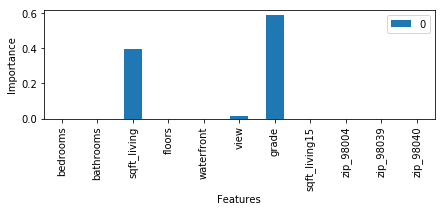

In [32]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(regr_dec.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
pd.DataFrame(regr_dec.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

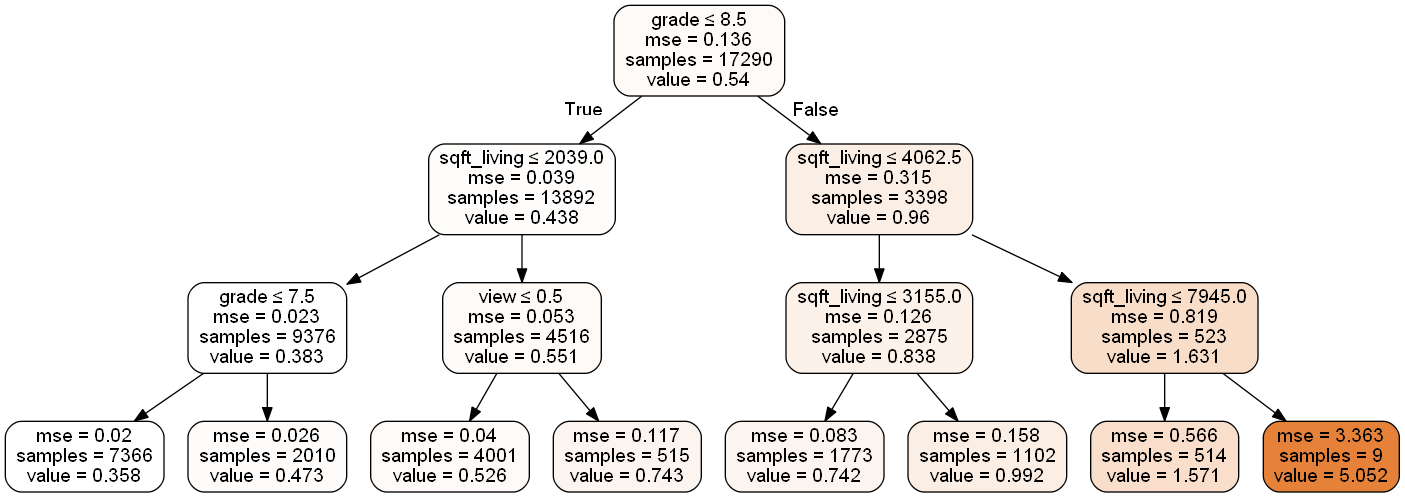

In [33]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(regr_dec, out_file=dot_data,
                     feature_names=X.columns,  
#                      class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

精度の評価

In [34]:
Y_pred=regr_dec.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y_test,Y_pred)

acr1_add=pd.DataFrame({'Model' : ["DecisionTree"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr1_2 = acr1_1.append(acr1_add)
display(acr1_2)

,Model,MSE,RMSE,MAE
0,DAY1,0.037000,0.193000,0.123000
0,Linear,0.041774,0.204386,0.139916
0,DecisionTree,0.060204,0.245366,0.160148


木の深さが少なく、十分な探索ができていないためかDAY1と比べても精度が落ちている

### 交差検証による探索

交差検証により、最適なmax_depthの値を調べる  
木の深さを1~10まで変化させる

In [35]:
# from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':list(range(1, 10))}
cv_dec = GridSearchCV(regr_dec,param_grid=param_grid,cv=5)
cv_dec.fit(X_test,Y_test)

print(cv_dec.best_score_)
print(cv_dec.best_params_)
print(cv_dec.best_estimator_)


0.5791338802806767
{'max_depth': 6}
DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')


最適なmax_depthの値が7だと分かった  

[1.18994235e-03 0.00000000e+00 3.05890730e-01 4.05101281e-04
 4.62317445e-02 2.91716663e-02 5.52279096e-01 1.15995023e-02
 4.79559588e-02 0.00000000e+00 5.27625896e-03]


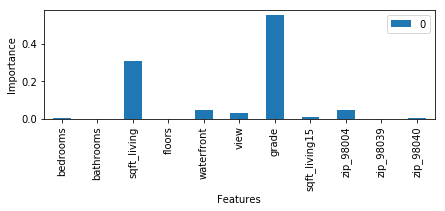

In [36]:
regr_dec_cv = cv_dec.best_estimator_

print(regr_dec_cv.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
pd.DataFrame(regr_dec_cv.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

木の深さが7となったことで、先ほどは使われていなかった変数が使われている  
この時の精度を確認する

In [37]:
#MSE,RMSE,MAEの計算
Y_pred=regr_dec_cv.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y_test,Y_pred)

acr1_add=pd.DataFrame({'Model' : ["DecisionTree+CV"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr1_3 = acr1_2.append(acr1_add)

display(acr1_3)


,Model,MSE,RMSE,MAE
0,DAY1,0.037000,0.193000,0.123000
0,Linear,0.041774,0.204386,0.139916
0,DecisionTree,0.060204,0.245366,0.160148
0,DecisionTree+CV,0.038036,0.195028,0.135452


線形回帰と比べても精度を上げることができた  
木の深さを増やし、使われる変数が増えたことで精度が向上したと考えられる

In [38]:
# 決定木は割愛
# from sklearn.tree import export_graphviz
# import pydotplus
# from IPython.display import Image
# from sklearn.externals.six import StringIO

# # 決定木の描画
# dot_data = StringIO() #dotファイル情報の格納先
# export_graphviz(regr_dec_cv, out_file=dot_data,
#                      feature_names=X.columns,  
# #                      class_names=["0","1"],  
#                      filled=True, rounded=True,  
#                      special_characters=True) 
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# Image(graph.create_png())

### (c)ランダムフォレストの使用

次はランダムフォレストを利用する  
パラメータは1つの決定木を使うパターンと揃える

score= 0.5949816777803667
[0.         0.         0.43952119 0.         0.00155106 0.02274177
 0.53499697 0.         0.00118902 0.         0.        ]


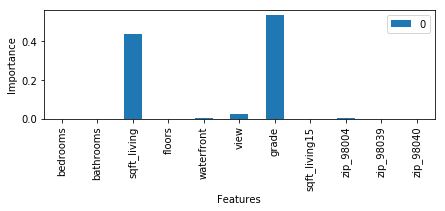

In [39]:
from sklearn.ensemble import RandomForestRegressor

regr_rf = RandomForestRegressor(n_estimators=10, criterion="mse" ,max_depth=3, min_samples_split=3, min_samples_leaf=3, random_state=1234)

regr_rf.fit(X_train, Y_train)
print("score=", regr_rf.score(X_train, Y_train))
# n_estimators 決定木の数

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(regr_rf.feature_importances_)
pd.DataFrame(regr_rf.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [40]:
#MSE,RMSE,MAEの計算
Y_pred=regr_rf.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y_test,Y_pred)

acr1_add=pd.DataFrame({'Model' : ["RandomForest"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr1_4 = acr1_3.append(acr1_add)

display(acr1_4)

,Model,MSE,RMSE,MAE
0,DAY1,0.037000,0.193000,0.123000
0,Linear,0.041774,0.204386,0.139916
0,DecisionTree,0.060204,0.245366,0.160148
0,DecisionTree+CV,0.038036,0.195028,0.135452
0,RandomForest,0.053762,0.231867,0.153353


1つの決定木利用と比べると、同じ深さの時よりは精度が向上している  
ただし、最適な木の深さを探索した場合にはおよばないことがわかる

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':list(range(1, 10))}
cv_rf = GridSearchCV(regr_rf,param_grid=param_grid,cv=5)
cv_rf.fit(X_test,Y_test)

print(cv_rf.best_score_)
print(cv_rf.best_params_)
print(cv_rf.best_estimator_)

0.6567223265686679
{'max_depth': 9}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)


[1.18994235e-03 0.00000000e+00 3.05890730e-01 4.05101281e-04
 4.62317445e-02 2.91716663e-02 5.52279096e-01 1.15995023e-02
 4.79559588e-02 0.00000000e+00 5.27625896e-03]


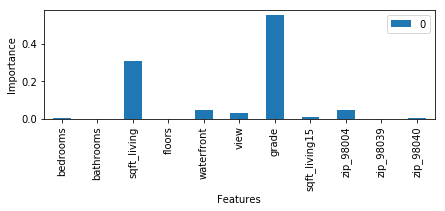

In [42]:
regr_rf_cv = cv_rf.best_estimator_

print(regr_dec_cv.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
pd.DataFrame(regr_dec_cv.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [43]:
#MSE,RMSE,MAEの計算
Y_pred=regr_rf_cv.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y_test,Y_pred)

acr1_add=pd.DataFrame({'Model' : ["RandomForest+CV"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr1_5 = acr1_4.append(acr1_add)

display(acr1_5)

,Model,MSE,RMSE,MAE
0,DAY1,0.037000,0.193000,0.123000
0,Linear,0.041774,0.204386,0.139916
0,DecisionTree,0.060204,0.245366,0.160148
0,DecisionTree+CV,0.038036,0.195028,0.135452
0,RandomForest,0.053762,0.231867,0.153353
0,RandomForest+CV,0.027543,0.165961,0.117419


今回のケースでの精度は、ランダムフォレスト、決定木は交差検証後の値を使うと  
ランダムフォレスト > 決定木 > 線形回帰  
となっていた。

## 5.精度向上への取り組み

一通り、モデルの作成と精度の評価を行ったところで、精度向上への取り組みを行う  
気になるのは、線形回帰を使った場合でDAY1より精度が落ちていることである

この原因として考えられるのは先ほども書いたように、重要な説明変数を落としていることが予想できる.  
そのうえで、最初のほうの相関係数を見ると、latが相関係数0.31と閾値の基準を満たしているのに、多重共線性の排除のために捨ててしまっている。
そしてzipcodeは相関係数による閾値選定で3つしか残っていない
(実はコードミスでlatがdropできていなかった時のほうが精度はよかった)


そこで、多重共線性を排除する際にlat,longを残すよう、偏回帰係数の高いzipcodeだけを落とす  
(ただし、longは相関係数が低いためにどちらにしろ後々落とされる)

In [44]:
df2_data_vif = df_data_02_2.drop(["price"],axis=1)
for cname in "lat","long",:  
    Y2_vif=df2_data_vif[cname]
    X2_vif=df2_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X2_vif, Y2_vif)
#     print(X2_vif.columns)
#     print(regr.coef_)
    coef = pd.DataFrame(columns=X2_vif.columns,data=[regr.coef_])
    coef.sort_values(by=0,axis=1,ascending=False, inplace=True)
#     print(cname,":" ,regr.coef_)
    pd.set_option('display.max_columns', None)
    print(cname)
    display(coef)

lat


,zip_98011,zip_98072,zip_98028,zip_98077,zip_98155,zip_98019,zip_98177,zip_98133,zip_98034,zip_98125,zip_98014,zip_98053,zip_98052,zip_98033,zip_98115,zip_98117,zip_98103,zip_98107,zip_98105,zip_98199,zip_98119,zip_98074,zip_98102,zip_98109,zip_98112,zip_98039,zip_98008,zip_98004,zip_98007,zip_98005,zip_98122,zip_98075,zip_98144,zip_98024,zip_98029,zip_98116,zip_98006,zip_98040,zip_98065,zip_98108,zip_98118,zip_98126,zip_98136,zip_98027,zip_98106,zip_98056,zip_98178,zip_98059,zip_98045,zip_98146,zip_98168,zip_98055,zip_98058,zip_98166,zip_98188,zip_98148,zip_98070,zip_98031,zip_98198,zip_98038,zip_98042,zip_98032,zip_98030,zip_98010,zip_98003,zip_98002,yr_renovated_bin,sold_year,grade,sold_month,sold_day,yr_built,sqft_living15,sqft_lot15,id,sqft_lot,sqft_living,bathrooms,bedrooms,view,condition,floors,zip_98092,waterfront,zip_98023,long,zip_98022
0,0.449322,0.448487,0.447142,0.446984,0.444221,0.444046,0.428365,0.423194,0.41474,0.406684,0.383789,0.382525,0.378709,0.375214,0.375079,0.372949,0.364194,0.356474,0.355288,0.332908,0.326769,0.325758,0.32361,0.323232,0.319414,0.31795,0.31215,0.309816,0.307845,0.307032,0.299908,0.290421,0.27657,0.267881,0.263767,0.259151,0.254834,0.253094,0.242793,0.23919,0.234806,0.230652,0.224313,0.22393,0.223073,0.205396,0.191655,0.190215,0.189853,0.188865,0.178983,0.152974,0.143243,0.142737,0.137729,0.125025,0.100954,0.098911,0.07974,0.073626,0.064469,0.06423,0.063976,0.037986,0.004512,0.003164,0.000989,0.000602,0.000461,0.000032,0.000013,0.000005,5.299672e-07,2.393200e-09,1.175390e-13,-5.752086e-09,-1.048055e-07,-0.000068,-0.000188,-0.00048,-0.000842,-0.001559,-0.002023,-0.00506,-0.00543,-0.04993,-0.083068


long


,zip_98045,zip_98014,zip_98065,zip_98024,zip_98019,zip_98029,zip_98053,zip_98075,zip_98010,zip_98022,zip_98074,zip_98077,zip_98027,zip_98038,zip_98052,zip_98008,zip_98072,zip_98042,zip_98007,zip_98059,zip_98006,zip_98058,zip_98005,zip_98033,zip_98011,zip_98056,zip_98034,zip_98092,zip_98004,zip_98031,zip_98030,zip_98055,zip_98040,zip_98028,zip_98039,zip_98002,zip_98178,zip_98118,zip_98105,zip_98155,zip_98125,zip_98115,zip_98112,zip_98188,zip_98122,yr_renovated_bin,zip_98144,yr_built,sqft_living,sqft_lot15,sqft_lot,id,sqft_living15,sold_day,sold_year,sold_month,condition,bedrooms,floors,view,bathrooms,grade,zip_98032,waterfront,zip_98108,zip_98102,zip_98168,zip_98133,zip_98103,zip_98198,zip_98003,zip_98109,zip_98148,zip_98177,zip_98119,zip_98106,zip_98166,zip_98146,zip_98107,zip_98117,zip_98126,zip_98023,zip_98199,zip_98136,zip_98116,lat,zip_98070
0,0.525523,0.450977,0.430281,0.383222,0.354664,0.290097,0.281952,0.275504,0.269891,0.262514,0.25689,0.248954,0.247236,0.243801,0.187965,0.185479,0.180499,0.160269,0.158655,0.149278,0.148799,0.137573,0.132932,0.119537,0.113051,0.107799,0.103855,0.100341,0.095748,0.090956,0.086292,0.083046,0.070621,0.068231,0.068011,0.057727,0.043242,0.019152,0.013297,0.011067,0.010097,0.006972,0.006139,0.003456,0.002425,0.001985,0.000895,0.000034,0.000001,7.006666e-08,1.639155e-08,-8.407323e-14,-3.014588e-07,-0.000009,-0.000031,-0.000057,-0.000057,-0.000279,-0.000435,-0.000503,-0.000684,-0.000731,-0.001426,-0.008104,-0.011624,-0.017635,-0.01951,-0.030953,-0.035912,-0.036225,-0.038247,-0.045317,-0.045583,-0.055725,-0.061677,-0.063277,-0.064523,-0.068068,-0.068103,-0.069645,-0.080352,-0.093145,-0.093235,-0.09358,-0.095441,-0.09691,-0.186841


それぞれから最も偏回帰係数が高いものを落とす

In [45]:
drop_col=["zip_98011","zip_98045"]
df2_data_02_3 = df_data_02_2.drop(drop_col,axis=1)

In [ ]:
df2_data_vif = df2_data_02_3.drop(["price"],axis=1)
for cname in df2_data_vif.columns:  
    Y2_vif=df2_data_vif[cname]
    X2_vif=df2_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X2_vif, Y2_vif)
    rsquared = regr.score(X2_vif,Y2_vif)
    vif =1/(1-np.power(rsquared,2))
    if(vif>10): print(cname,":" ,vif)

10以上のVIFをもつ説明変数がなくなり、多重共線性を解消することができた

In [ ]:
df2_data_03=df2_data_02_3
# print(df2_data_03)

先ほど同様に、モデルの作成と精度の評価を行う

In [ ]:
# 説明変数と目的変数に分ける

# 相関係数が0.3以上の変数を抽出し、説明変数として設定する
# 目的変数はprice
corr = pd.DataFrame(columns=df2_data_03.columns,data= df2_data_03.corr())
# print(corr.loc["price","bedrooms"])

# print(df2_data_03.columns)
X2_columns=[]
for col in df2_data_03.columns:
    if(corr.loc["price",col]>0.2):
        X2_columns.append(col)
# print(X2_columns)
X2=df2_data_03[X2_columns]
X2=X2.drop("price",1)
Y2=df2_data_03["price"]
# print(X.head())
# print(Y.head())
print(X2.columns)

In [ ]:
# 相関行列を確認し、実際に相関係数が閾値以上の目的変数が抽出されていることを確認
# df2_corr = df2_data_03.corr()
# df2_corr.sort_values(by="price",axis=0,ascending=False, inplace=True)
# df2_corr.style.background_gradient().format('{:.2f}')

### 説明変数の標準化

In [ ]:
# 説明変数の標準化を行う

from sklearn.preprocessing import StandardScaler
stdsc=StandardScaler()
# print(stdsc.fit_transform(X))
X2_std = pd.DataFrame(columns=X2.columns,data=stdsc.fit_transform(X2))
# X2_std = stdsc.fit_transform(X)

# display(X2_std.head())

In [ ]:
# 2割をテストデータとして利用
from sklearn.model_selection import train_test_split
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2,Y2,test_size=0.2,random_state=3)


### (a)線形回帰を使った場合

In [ ]:
from sklearn.linear_model import LinearRegression

#回帰
regr2_lin = LinearRegression(fit_intercept=True)
regr2_lin.fit(X2_train,Y2_train)

# 回帰変数および回帰切片の表示
print(regr2_lin.coef_)
print(regr2_lin.intercept_)
#print(regr.get_params())

#決定係数の表示
# print("決定係数=%s"%round(regr2_lin.score(X2_test,Y2_test),3))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error

#MSE,RMSE,MAEの計算
Y2_pred=regr2_lin.predict(X2_test)
mse=mean_squared_error(Y2_test,Y2_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y2_test,Y2_pred)

acr2_0=pd.DataFrame({'Model' : ["DAY1"],
                    'MSE' : [0.037],
                    'RMSE' : [0.193],
                  'MAE' : [0.123],})

acr2_add=pd.DataFrame({'Model' : ["Linear"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr2_1 = acr2_0.append(acr2_add)

# display(acr2_1)

### (b) 1つの決定木を使った方法

1つの決定木を使った方法での回帰と精度の評価を行う  
パラメータは基本的に講義と同じものを使用し、交差検証でmax_depthの最適値を探索する

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

regr2_dec = DecisionTreeRegressor(criterion="mse", max_depth=3, min_samples_split=3, min_samples_leaf=3, random_state=1234)
# min_sample_leaf 最低でも葉が3つ残る切り方
regr2_dec = regr2_dec.fit(X2_train, Y2_train)
# max_depth:木の深さ　どこかで決定木を打ち切る 過学習の防止
# print("score=", regr2_dec.score(X2_train, Y2_train))
# print(regr2_dec.predict(X2_test)) #予測したい場合

In [ ]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# print(regr2_dec.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
# pd.DataFrame(regr2_dec.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
# plt.ylabel("Importance")
# plt.xlabel("Features")
# plt.show()

In [ ]:
Y2_pred=regr2_dec.predict(X2_test)
mse=mean_squared_error(Y2_test,Y2_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y2_test,Y2_pred)

acr2_add=pd.DataFrame({'Model' : ["DecisionTree"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr2_2 = acr2_1.append(acr2_add)
# display(acr2_2)

### 交差検証による探索

交差検証により、最適なmax_depthの値を調べる  
木の深さを1~10まで変化させる

In [ ]:
# from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':list(range(1, 10))}
cv2_dec = GridSearchCV(regr2_dec,param_grid=param_grid,cv=5)
cv2_dec.fit(X2_test,Y2_test)

print(cv2_dec.best_score_)
print(cv2_dec.best_params_)
print(cv2_dec.best_estimator_)

In [ ]:
#MSE,RMSE,MAEの計算

regr2_dec_cv = cv2_dec.best_estimator_
Y2_pred=regr2_dec_cv.predict(X2_test)
mse=mean_squared_error(Y2_test,Y2_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y2_test,Y2_pred)

acr2_add=pd.DataFrame({'Model' : ["DecisionTree+CV"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr2_3 = acr2_2.append(acr2_add)

# display(acr2_3)


In [ ]:
# 決定木は割愛
# from sklearn.tree import export_graphviz
# import pydotplus
# from IPython.display import Image
# from sklearn.externals.six import StringIO

# # 決定木の描画
# dot_data = StringIO() #dotファイル情報の格納先
# export_graphviz(regr2_dec_cv, out_file=dot_data,
#                      feature_names=X.columns,  
# #                      class_names=["0","1"],  
#                      filled=True, rounded=True,  
#                      special_characters=True) 
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# Image(graph.create_png())

### (c)ランダムフォレストの使用

次はランダムフォレストを利用する  
パラメータは1つの決定木を使うパターンと揃える

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr2_rf = RandomForestRegressor(n_estimators=10, criterion="mse" ,max_depth=3, min_samples_split=3, min_samples_leaf=3, random_state=1234)

regr2_rf.fit(X2_train, Y2_train)
print("score=", regr2_rf.score(X2_train, Y2_train))
# n_estimators 決定木の数

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# print(regr2_rf.feature_importances_)
# pd.DataFrame(regr2_rf.feature_importances_, index=X2.columns).plot.bar(figsize=(7,2))
# plt.ylabel("Importance")
# plt.xlabel("Features")
# plt.show()

In [ ]:
#MSE,RMSE,MAEの計算
Y2_pred=regr2_rf.predict(X2_test)
mse=mean_squared_error(Y2_test,Y2_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y2_test,Y2_pred)

acr2_add=pd.DataFrame({'Model' : ["RandomForest"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr2_4 = acr2_3.append(acr2_add)

# display(acr2_4)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':list(range(1, 10))}
cv2_rf = GridSearchCV(regr2_rf,param_grid=param_grid,cv=5)
cv2_rf.fit(X2_test,Y2_test)

print(cv2_rf.best_score_)
print(cv2_rf.best_params_)
print(cv2_rf.best_estimator_)

In [ ]:
regr2_rf_cv = cv2_rf.best_estimator_

print(regr2_dec_cv.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
pd.DataFrame(regr2_dec_cv.feature_importances_, index=X2.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [ ]:
#MSE,RMSE,MAEの計算
Y2_pred=regr2_rf_cv.predict(X2_test)
mse=mean_squared_error(Y2_test,Y2_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(Y2_test,Y2_pred)

acr2_add=pd.DataFrame({'Model' : ["RandomForest+CV"],
                    'MSE' : [mse],
                    'RMSE' : [rmse],
                  'MAE' : [mae],})

acr2_5 = acr2_4.append(acr2_add)

# display(acr2_5)

In [ ]:
print("lat,longをdropさせた場合")
display(acr1_5)
print("lat,longを残した場合")
display(acr2_5)

regr2_dec_cv = cv2_dec.best_estimator_

# print(regr2_dec_cv.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
pd.DataFrame(regr2_dec_cv.feature_importances_, index=X2.columns).plot.bar(figsize=(7,2))
print("RandomForest使用時の説明変数の重要度")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

latを残すようにしたことで、どの手法でも精度が向上したことが確認できる  
MSEを例にとると、0.1程度の向上が見られ、説明変数1つでも、モデルの選択と同程度の精度への影響があることが分かっ。た 
説明変数の重要度を見ても、latが上から3番目となっている。
  
またこの場合でも精度は  
ランダムフォレスト > 1つの決定木 > 線形回帰  
となっている。  
複数の決定木を使うランダムフォレストが、1つの決定木を使うより精度が良いのはなんとなく分かるが、
線形回帰よりも良くなる理由を考えるため、重要な説明変数3つについて散布図を確認してみた。

In [ ]:
for col in "grade","sqft_living","lat":
    if (col != 'price') & ( col != 'date'):
        df_data[[col,'price']].plot(kind='scatter',x=col,y='price')

gradeとsqft_livingについては直線に近く、線形回帰でも収まりがよさそうだが、latについては線形とは言い難い。  
一方で決定木を利用すれば、lat=47.53付近で線が引けそうに見える。  
このように、重要な説明変数の中に線形回帰の苦手なタイプが含まれていたことが、今回の精度の結果につながったのでは、と考えた。
  
そう考えると、今回は説明変数を絞り込む際に相関係数を使ったが、それだと上手くいかないパターンが出てくることも考えられる。  
講義でも触れられていたように相関係数以外で、ランダムフォレストを説明変数の絞り込みに使うなどの方法も散布図を見たうえで検討したほうが良いと感じた。

## 6.まとめ

まず、前処理の段階でDAY1に加えて下記の取り組みを行った   
- カテゴリカル変数処理の改善
- 多重共線性の排除
- 相関係数による閾値の絞り込み
- データの標準化
  
そして、下記のモデルの作成と、精度の評価を行った
- 線形回帰
- 1つの決定木
- ランダムフォレスト
  
その結果、精度は、  
ランダムフォレスト > (DAY1) > 1つの決定木 > 線形回帰  
の順になった。  
  
線形回帰でDAY1より悪くなったことに疑問を覚え、目的変数の絞り込みの部分を見直したところ、  
ランダムフォレスト > 1つの決定木 > 線形回帰 > (DAY1)  
と、モデルごとの順序は同じままに、DAY1より精度を上げることができた。

モデルによる精度の違いについては、線形回帰では対処しづらいデータの重要性が高いことが原因だと予測され、相関係数を使った説明変数の絞り込みの見直しが必要だと感じた。

## 7.感想

まず、全体的に時間がかかり、提出が遅くなってしまい申し訳ありませんでした。  
データを細かく見ずに考え込んでしまったケースがあったので、pythonの練習もかねて積極的にデータの表示を行っていこうと思います。  
  
課題の内容としては、
多重共線性が発生したときにどの変数を捨てるのか、どうやって重要な説明変数を残すのか、といった部分や  
出てきた精度をどう捉えれば良いのか、といった部分での難しさ、奥深さを感じました。

python自体もまだまだ不慣れですが、今回はセルの再実行性を担保するよう気を付けました。
おかげで変数の数はどんどんと増えていきましたが、セルの実行順序をそれほど意識する必要がなくなったのは良かったかな、と感じました。

また次回の課題もありますが、次の発表の時にはもう少し速度と精度を上げられるように頑張ります。